In [68]:
import sys, os, glob
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
oceandirect_path = 'C:/Program Files/Ocean Optics/OceanDirect SDK/Python/'
sys.path.append(os.path.abspath(oceandirect_path))
from Read_Spectrum import *
import pandas as pd
import matplotlib.cm as cm
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [16]:
# read_spectra(read_all_serial_numbers()[0], 30000, 1, './Spectral_Files/Testing.csv')

In [61]:
data = np.loadtxt('./Spectral_Files/Testing.csv', delimiter=',', skiprows=1)
x_wavelength = data[:,0]
y = data[:,1]

In [63]:
left_closest_value = min(x_wavelength, key=lambda x: abs(x - 590))
right_closest_value = min(x_wavelength, key=lambda x: abs(x - 600))

# Get the index of the closest values using numpy.where
left_index = np.where(x_wavelength == left_closest_value)[0][0]
right_index = np.where(x_wavelength == right_closest_value)[0][0]

print(left_index, right_index)

185 354


In [88]:
# Spectral resolution
resolution = (max(x_wavelength)-min(x_wavelength))/len(x_wavelength)
print("Spectral resolution =", resolution, "nm per pixel")

Spectral resolution = 0.054382097557763256 nm per pixel


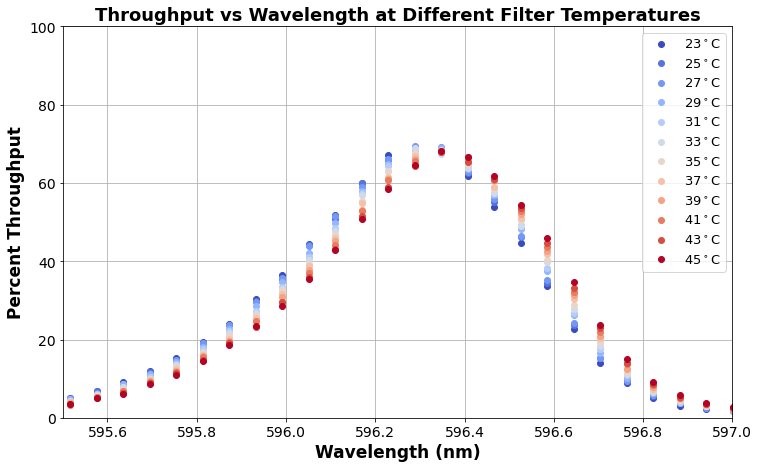

In [117]:
# Temperature refers to the sensor on the outer lens tube rim. Median intensity over 5 images with 30000 us integration time

# Step 1: List the CSV files
csv_files = glob.glob('./Spectral_Files/*.csv')

# Load throughput files
throughput_23_29 = pd.read_csv('./Spectral_Files/Base_Throughput_350.csv')
throughput_31_45 = pd.read_csv('./Spectral_Files/Base_Throughput.csv')

# Step 2: Initialize a plot
# plt.figure(figsize=(10, 6))
plt.figure(figsize=(12, 7.2))


# Step 3: Extract temperatures and normalize them
temperatures = []
for file in csv_files:
    if file.endswith('C.csv'):
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        temperatures.append(temperature)

# Normalize temperatures to the range [0, 1]
norm = plt.Normalize(min(temperatures), max(temperatures))
cmap = cm.coolwarm

# Step 4: Iterate through the CSV files and plot
for file in csv_files:
    if file.endswith('C.csv'):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Extract the temperature from the file name
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        
        # Select the appropriate throughput file based on temperature range
        if 23 <= temperature <= 29:
            throughput = throughput_23_29
        elif 31 <= temperature <= 45:
            throughput = throughput_31_45
        else:
            continue  # Skip temperatures outside the specified ranges
        
        # Normalize the intensity values
        normalized_intensity = df.iloc[:, 1:].div(throughput.iloc[:, 1:], axis=0).median(axis=1)
        
        # Combine the wavelengths with their corresponding normalized spectral intensity
        result = pd.DataFrame({
            'Wavelength': df.iloc[:, 0],
            'Normalized_Spectral_Intensity': normalized_intensity
        })
        
        # Get the color from the colormap
        color = cmap(norm(temperature))
        
        # Plot the data
        plt.plot(result['Wavelength'], result['Normalized_Spectral_Intensity']*100, marker='o', linestyle=' ', label=f'{temperature}$^\circ$C', color=color)

# Step 5: Customize the plot
plt.xlim(595.5, 597)
plt.ylim(0, 100)
plt.title('Throughput vs Wavelength at Different Filter Temperatures', fontweight='bold', fontsize=18)
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=17)
plt.ylabel('Percent Throughput', fontweight='bold', fontsize=17)
plt.legend(fontsize=13)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)

# Step 6: Show the plot
plt.show()

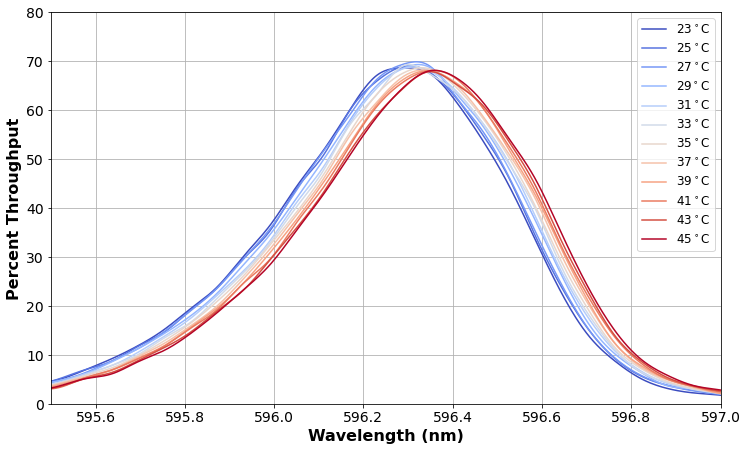

In [48]:
# Interpolated data (smooth)

# Step 1: List the CSV files
csv_files = glob.glob('./Spectral_Files/*.csv')

# Load throughput files
throughput_23_29 = pd.read_csv('./Spectral_Files/Base_Throughput_350.csv')
throughput_31_45 = pd.read_csv('./Spectral_Files/Base_Throughput.csv')

# Step 2: Initialize a plot
plt.figure(figsize=(12, 7.2))

# Step 3: Extract temperatures and normalize them
temperatures = []
for file in csv_files:
    if file.endswith('C.csv'):
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        temperatures.append(temperature)

# Normalize temperatures to the range [0, 1]
norm = plt.Normalize(min(temperatures), max(temperatures))
cmap = cm.coolwarm

# Step 4: Iterate through the CSV files and plot
for file in csv_files:
    if file.endswith('C.csv'):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Extract the temperature from the file name
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        
        # Select the appropriate throughput file based on temperature range
        if 23 <= temperature <= 29:
            throughput = throughput_23_29
        elif 31 <= temperature <= 45:
            throughput = throughput_31_45
        else:
            continue  # Skip temperatures outside the specified ranges
        
        # Normalize the intensity values
        normalized_intensity = df.iloc[:, 1:].div(throughput.iloc[:, 1:], axis=0).median(axis=1)
        
        # Combine the wavelengths with their corresponding normalized spectral intensity
        result = pd.DataFrame({
            'Wavelength': df.iloc[:, 0],
            'Normalized_Spectral_Intensity': normalized_intensity
        })
        
        # Interpolate the normalized spectral intensity data
        spline = UnivariateSpline(result['Wavelength'], result['Normalized_Spectral_Intensity'], s=0)
        fine_wavelengths = np.linspace(595, 597, 500)  # Fine grid between 595 and 597 nm
        interpolated_intensity = spline(fine_wavelengths)
        
        # Get the color from the colormap
        color = cmap(norm(temperature))
        
        # Plot the interpolated data
        plt.plot(fine_wavelengths, interpolated_intensity * 100, marker=' ', linestyle='-', label=f'{temperature}$^\circ$C', color=color)

# Step 5: Customize the plot
plt.xlim(595.5, 597)
plt.ylim(0, 80)
# plt.title('Throughput vs Wavelength at Different Filter Temperatures', fontweight='bold', fontsize=18)
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=16)
plt.ylabel('Percent Throughput', fontweight='bold', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

In [97]:
# Now calculate the rate of change in thorughput
# Step 1: List the CSV files
csv_files = glob.glob('./Spectral_Files/*.csv')

# Step 2: Extract temperatures and initialize lists for peak wavelengths
temperatures = []
peak_wavelengths = []

for file in csv_files:
    if file.endswith('C.csv'):
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        temperatures.append(temperature)

# Step 3: Iterate through the CSV files and find peak wavelengths
for file in csv_files:
    if file.endswith('C.csv'):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Extract the temperature from the file name
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        
        # Calculate the median intensity across all columns (excluding the first column which is wavelength)
        median_intensity = df.iloc[:, 1:].median(axis=1)
        
        # Combine the wavelengths with their corresponding median spectral intensity
        result = pd.DataFrame({
            'Wavelength': df.iloc[:, 0],
            'Median_Spectral_Intensity': median_intensity
        })
        
        # Find the peak wavelength
        peak_wavelength = result.loc[result['Median_Spectral_Intensity'].idxmax(), 'Wavelength']
        peak_wavelengths.append(peak_wavelength)

# Step 4: Calculate the average change in peak wavelength per degree Celsius
temperature_diffs = np.diff(temperatures)
wavelength_diffs = np.diff(peak_wavelengths)
average_change_per_C = np.mean(wavelength_diffs / temperature_diffs)

print(f'Average change in peak wavelength per degree Celsius: {average_change_per_C:.4f} nm/°C')

Average change in peak wavelength per degree Celsius: 0.0027 nm/°C


In [64]:
# Now calculate the rate of change in thorughput
# Step 1: List the CSV files
csv_files = glob.glob('./Spectral_Files/*.csv')

# Step 2: Extract temperatures and initialize lists for peak wavelengths
temperatures = []
peak_wavelengths = []

for file in csv_files:
    if file.endswith('C.csv'):
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        temperatures.append(temperature)

        df = pd.read_csv(file)

        median_intensity = df.iloc[:, 1:].median(axis=1)

        result = pd.DataFrame({
            'Wavelength': df.iloc[:, 0],
            'Median_Spectral_Intensity': median_intensity
        })
        
        # Interpolate the median spectral intensity data
        spline = UnivariateSpline(result['Wavelength'], result['Median_Spectral_Intensity'], s=0)
        fine_wavelengths = np.linspace(595, 597, 1000)
        interpolated_intensity = spline(fine_wavelengths)
        
        # Find the peak wavelength from the interpolated data
        peak_wavelength = fine_wavelengths[np.argmax(interpolated_intensity)]
        peak_wavelengths.append(peak_wavelength)

print(peak_wavelengths)

# Step 4: Calculate the average change in peak wavelength per degree Celsius
temperature_diffs = np.diff(temperatures)
wavelength_diffs = np.diff(peak_wavelengths)
print(wavelength_diffs)
average_change_per_C = np.mean(wavelength_diffs / temperature_diffs)

print(f'Average change in peak wavelength per degree Celsius: {average_change_per_C:.6f} nm/°C')

[596.2952952952953, 596.3033033033033, 596.3233233233233, 596.3193193193193, 596.3173173173174, 596.3113113113113, 596.3353353353353, 596.3453453453453, 596.3453453453453, 596.3493493493494, 596.3513513513514, 596.3573573573574]
[ 0.00800801  0.02002002 -0.004004   -0.002002   -0.00600601  0.02402402
  0.01001001  0.          0.004004    0.002002    0.00600601]
Average change in peak wavelength per degree Celsius: 0.002821 nm/°C


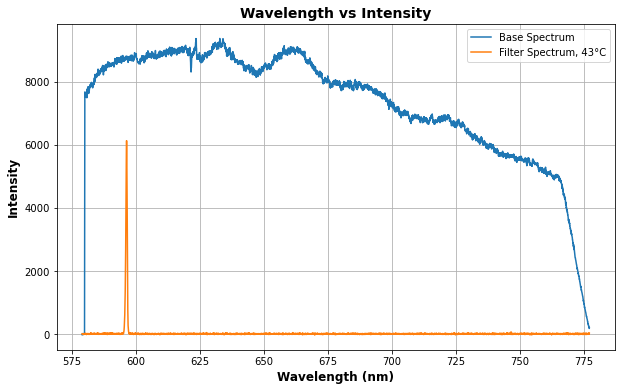

In [48]:
df_base = pd.read_csv('./Spectral_Files/Base_Throughput.csv')
df = pd.read_csv('./Spectral_Files/Filter_Throughput_23C.csv')

# Step 2: Calculate the average spectral intensity
# Assuming the first column is 'Wavelength' and the next five columns are spectral data
median_base_intensity = df_base.iloc[:, 1:].median(axis=1)
median_spectral_intensity = df.iloc[:, 1:].median(axis=1)

# Step 3: Combine the wavelengths with their corresponding average spectral intensity
result_base = pd.DataFrame({
    'Wavelength': df_base.iloc[:, 0],
    'Median_Spectral_Intensity': median_base_intensity
})
result = pd.DataFrame({
    'Wavelength': df.iloc[:, 0],
    'Median_Spectral_Intensity': median_spectral_intensity
})

# Step 4: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(result_base['Wavelength'], result_base['Median_Spectral_Intensity'], marker=' ', linestyle='-', label='Base Spectrum')
plt.plot(result['Wavelength'], result['Median_Spectral_Intensity'], marker=' ', linestyle='-', label='Filter Spectrum, 43°C')
plt.title('Wavelength vs Intensity', fontweight='bold', fontsize=14)
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=12)
plt.ylabel('Intensity', fontweight='bold', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Calculate the average percent transmission for the 31C filter at all wavelengths outside +/- 2nm from the wavelength of peak emission

In [129]:
# Load the spectral data for 31°C
file_31C = './Spectral_Files/Filter_Throughput_31C.csv'
baseline = pd.read_csv('./Spectral_Files/Base_Throughput.csv')

# Read the CSV file into a DataFrame
df = pd.read_csv(file_31C)

# Calculate the median raw intensity values
median_raw_intensity = df.iloc[:, 1:].median(axis=1)

# Combine the wavelengths with their corresponding median raw intensity
result = pd.DataFrame({
    'Wavelength': df.iloc[:, 0],
    'Median_Raw_Intensity': median_raw_intensity
})

# Find the peak wavelength as the wavelength with the highest median raw intensity
peak_wavelength = df.iloc[:, 0][median_raw_intensity.idxmax()]

# Normalize the raw intensity values with the baseline data
normalized_intensity = df.iloc[:, 1:].div(baseline.iloc[:, 1:], axis=0).median(axis=1)

# Combine the wavelengths with their corresponding normalized spectral intensity
normalized_result = pd.DataFrame({
    'Wavelength': df.iloc[:, 0],
    'Normalized_Spectral_Intensity': normalized_intensity
})

# Filter the data to exclude wavelengths within ±2 nm of the peak wavelength
outside_range_mask = (normalized_result['Wavelength'] < (peak_wavelength - 2)) | (normalized_result['Wavelength'] > (peak_wavelength + 2))
filtered_wavelengths = normalized_result['Wavelength'][outside_range_mask]
filtered_intensity = normalized_result['Normalized_Spectral_Intensity'][outside_range_mask]

# Calculate the average percent transmission outside the ±2 nm range
average_percent_transmission = np.mean(filtered_intensity) * 100

print(f'Average percent transmission outside ±2 nm from the peak wavelength ({peak_wavelength:.2f} nm): {average_percent_transmission:.2f}%')

Average percent transmission outside ±2 nm from the peak wavelength (596.29 nm): 0.39%


Calculate the peak wavelength and FWHM for dark subtracted, normalized, interpolated data at different temperatures (normal incidence).

In [20]:
def calculate_fwhm(wavelengths, intensities):
    half_max = np.max(intensities) / 2.0
    f = interp1d(wavelengths, intensities - half_max, kind='linear')
    interpolated_values = f(wavelengths)
    roots = np.where(np.diff(np.sign(interpolated_values)))[0]
    if len(roots) >= 2:
        fwhm = wavelengths[roots[-1]] - wavelengths[roots[0]]
    else:
        fwhm = np.nan
    return fwhm

In [45]:
# Find the FWHM and peak wavelength based on interpolated temperature data

# Step 1: List the CSV files
csv_files = glob.glob('./Spectral_Files/*.csv')
dark_frame = pd.read_csv('./Spectral_Files/Darks/Dark_30000.csv')
median_dark_intensity = dark_frame.iloc[:, 1:].median(axis=1)

# Load throughput files
throughput_23_29 = pd.read_csv('./Spectral_Files/Base_Throughput_350.csv')
throughput_31_45 = pd.read_csv('./Spectral_Files/Base_Throughput.csv')

# Step 3: Extract temperatures and normalize them
temperatures = []
for file in csv_files:
    if file.endswith('C.csv'):
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        temperatures.append(temperature)

peak_wavelengths = []
FWHMs = []

# Step 4: Iterate through the CSV files and plot
for file in csv_files:
    if file.endswith('C.csv'):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Extract the temperature from the file name
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        
        # Select the appropriate throughput file based on temperature range
        if 23 <= temperature <= 29:
            throughput = throughput_23_29
        elif 31 <= temperature <= 45:
            throughput = throughput_31_45
        else:
            continue  # Skip temperatures outside the specified ranges

        median_base_intensity = throughput.iloc[:, 1:].median(axis=1) - median_dark_intensity
        median_spectral_intensity = df.iloc[:, 1:].median(axis=1) - median_dark_intensity
        normalized_intensity = median_spectral_intensity.div(median_base_intensity, axis=0)
        
        # Combine the wavelengths with their corresponding normalized spectral intensity
        result = pd.DataFrame({
            'Wavelength': df.iloc[:, 0],
            'Normalized_Spectral_Intensity': normalized_intensity
        })
        
        # Interpolate the normalized spectral intensity data
        spline = UnivariateSpline(result['Wavelength'], result['Normalized_Spectral_Intensity'], s=0)
        fine_wavelengths = np.linspace(594, 598, 1000)  # Fine grid between 594 and 598 nm
        interpolated_intensity = spline(fine_wavelengths)

        fwhm = calculate_fwhm(fine_wavelengths, interpolated_intensity)
        FWHMs.append(fwhm)

        peak_wavelength = fine_wavelengths[np.argmax(interpolated_intensity)]
        peak_wavelengths.append(peak_wavelength)

print(temperatures)
print(peak_wavelengths)
print(FWHMs)

[23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45]
[596.2942942942943, 596.3023023023023, 596.3183183183183, 596.3143143143143, 596.3063063063063, 596.3023023023023, 596.3263263263264, 596.3383383383383, 596.3423423423424, 596.3463463463463, 596.3503503503504, 596.3623623623623]
[0.6006006006006146, 0.6006006006006146, 0.6006006006006146, 0.604604604604674, 0.6006006006006146, 0.6046046046045603, 0.604604604604674, 0.6086086086086198, 0.6126126126126792, 0.6086086086086198, 0.604604604604674, 0.6126126126126792]


Calculate FWHM and peak wavelength using Gaussian fit to the raw data

In [69]:
def gaussian(x, amplitude, centroid, sigma):
    return amplitude * np.exp(-(x - centroid)**2 / (2 * sigma**2))

In [71]:
# Find the FWHM and peak wavelength based on Gaussian fit to raw data

# Step 1: List the CSV files
csv_files = glob.glob('./Spectral_Files/*.csv')
dark_frame = pd.read_csv('./Spectral_Files/Darks/Dark_30000.csv')
median_dark_intensity = dark_frame.iloc[:, 1:].median(axis=1)

# Load throughput files
throughput_23_29 = pd.read_csv('./Spectral_Files/Base_Throughput_350.csv')
throughput_31_45 = pd.read_csv('./Spectral_Files/Base_Throughput.csv')

# Step 3: Extract temperatures and normalize them
temperatures = []
for file in csv_files:
    if file.endswith('C.csv'):
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        temperatures.append(temperature)

centroids = []
FWHM_fits = []
CRLB_centroid_uncertainties = []
FWHM_uncertainties = []

# Step 4: Iterate through the CSV files and plot
for file in csv_files:
    if file.endswith('C.csv'):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Extract the temperature from the file name
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        
        # Select the appropriate throughput file based on temperature range
        if 23 <= temperature <= 29:
            throughput = throughput_23_29
        elif 31 <= temperature <= 45:
            throughput = throughput_31_45
        else:
            continue  # Skip temperatures outside the specified ranges

        median_base_intensity = throughput.iloc[:, 1:].median(axis=1) - median_dark_intensity
        median_spectral_intensity = df.iloc[:, 1:].median(axis=1) - median_dark_intensity
        normalized_intensity = median_spectral_intensity.div(median_base_intensity, axis=0)
        
        # Combine the wavelengths with their corresponding normalized spectral intensity
        result = pd.DataFrame({
            'Wavelength': df.iloc[:, 0],
            'Normalized_Spectral_Intensity': normalized_intensity
        })
        
        raw_wavelengths = result['Wavelength']
        raw_intensities = result['Normalized_Spectral_Intensity']

        # Skip the first 20 and the last 20 data points
        raw_wavelengths = raw_wavelengths[20:-20]
        raw_intensities = raw_intensities[20:-20]

        raw_peak_idx = np.argmax(raw_intensities)
        raw_peak_wavelength = raw_wavelengths[raw_peak_idx]
        fit_range = slice(max(0, raw_peak_idx - 20), min(len(raw_wavelengths), raw_peak_idx + 20)) # Roughly the size of the peak given spectral resolution

        # Perform Gaussian fit to the raw data
        initial_guess = [np.max(raw_intensities[fit_range]), raw_peak_wavelength, np.std(raw_wavelengths[fit_range])]
        bounds = ([-np.inf, -np.inf, 0], [np.inf, np.inf, np.inf])
        popt, pcov = curve_fit(gaussian, raw_wavelengths[fit_range], raw_intensities[fit_range], p0=initial_guess, bounds=bounds)

        # Identify variables and uncertainties from the best fit
        a_fit, centroid_fit, sigma_fit = popt
        uncertainties = np.sqrt(np.diag(pcov))
        a_uncertainty, centroid_uncertainty, sigma_uncertainty = uncertainties
        fwhm_fit = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
        fwhm_uncertainty = 2 * np.sqrt(2 * np.log(2)) * sigma_uncertainty

        FWHM_uncertainties.append(fwhm_uncertainty)

        residuals = raw_intensities[fit_range] - gaussian(raw_wavelengths[fit_range], *popt)
        noise_level = np.std(residuals)
        N = len(raw_wavelengths[fit_range])
        avg_signal = np.mean(raw_intensities[fit_range])
        SNR = avg_signal / noise_level # could take the average in this range rather than peak amplitude
        centroid_uncertainty_crlb = sigma_fit / (np.sqrt(N) * SNR) # Cramér-Rao lower bound for centroid uncertainty

        centroids.append(centroid_fit)
        FWHM_fits.append(fwhm_fit)
        CRLB_centroid_uncertainties.append(centroid_uncertainty_crlb)

print(centroids)
print(FWHM_fits)
print('-----------------')
print("Centroiding Uncertainty (CRLB) on Raw Data:", CRLB_centroid_uncertainties)
print("FWHM uncertainties", FWHM_uncertainties)

[596.2697292826925, 596.2762473266642, 596.2782492867084, 596.2888559484265, 596.2952194109057, 596.2998362722377, 596.306473882507, 596.3127508995883, 596.3195294726548, 596.3243735622821, 596.3321795854955, 596.337494639086]
[0.6306330167696065, 0.6338061530852184, 0.6318568303958875, 0.6352383130202952, 0.6329426411546198, 0.6321783160992368, 0.6321582821919899, 0.633698498021535, 0.631923453343561, 0.6350254894656668, 0.6323536592581129, 0.6341220960404291]
-----------------
Centroiding Uncertainty (CRLB) on Raw Data: [0.0055298017860741415, 0.005451400068773654, 0.005383305196804222, 0.005537589651992652, 0.005320721407813048, 0.005238981673752733, 0.005232597412320856, 0.005134215551191749, 0.00526476134693406, 0.005294531136623718, 0.005334818154305019, 0.0052625111130053335]
FWHM uncertainties [0.012691834127110616, 0.012686051136558693, 0.012486360787217154, 0.012908262978825143, 0.012403084339900112, 0.012143236373482944, 0.012140627495621652, 0.011895868018940844, 0.01217901

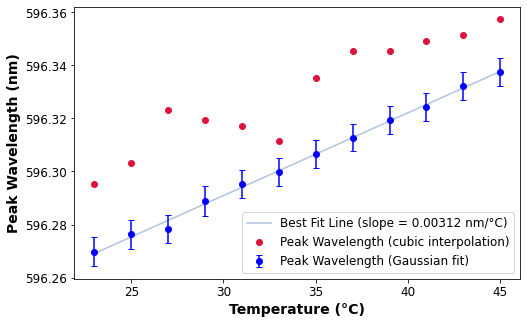

Slope of the line of best fit: 0.00311936866483499


In [76]:
coefficients = np.polyfit(temperatures, centroids, 1)
slope = coefficients[0]
intercept = coefficients[1]

# Generate the line of best fit
line_of_best_fit = np.polyval(coefficients, temperatures)

# Plot the data and the line of best fit
plt.figure(figsize=(8, 5))
plt.plot(temperatures, line_of_best_fit, color='lightsteelblue', label=f'Best Fit Line (slope = {slope:.5f} nm/°C)')
plt.plot(temperatures, peak_wavelengths, marker='o', linestyle=' ', label='Peak Wavelength (cubic interpolation)', color='crimson')
plt.errorbar(temperatures, centroids, yerr = CRLB_centroid_uncertainties, marker='o', linestyle=' ', label='Peak Wavelength (Gaussian fit)', color='blue', capsize=3)

plt.xlabel('Temperature (°C)', fontweight='bold', fontsize=14)
plt.ylabel('Peak Wavelength (nm)', fontweight='bold', fontsize=14)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

# Print the slope
print(f"Slope of the line of best fit: {slope}")

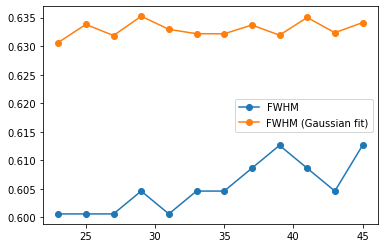

In [78]:
plt.plot(temperatures, FWHMs, marker='o', linestyle='-', label='FWHM')
plt.plot(temperatures, FWHM_fits, marker='o', linestyle='-', label='FWHM (Gaussian fit)')
plt.legend()

In [82]:
print('Average FWHM:', np.average(FWHM_fits))
print('Standard deviation in FWHM:', np.std(FWHM_fits))

Average FWHM: 0.6329947290705134
Standard deviation in FWHM: 0.0013348626620962036


Time to take real data now. The lamp has been on for about 20 minutes to warm up and my filter temperature is steady. Start by taking a base throughput spectrum and then different temperatures that are 2 C apart. Use 30000 microsecond exposure time and take 5 frames, then the median (or mean?) of those. Filter temperatures refer to the outer rim, with one sensor. Taken on 8/7/24

In [15]:
# No filter 10:22AM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Base_Throughput.csv')

In [14]:
# 31 C rim 10:23AM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_31C.csv')

In [13]:
# 33 C rim 10:26AM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_33C.csv')

In [12]:
# 35 C rim 10:28AM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_35C.csv')

In [11]:
# 37 C rim 10:31AM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_37C.csv')

In [10]:
# 39 C rim 10:35AM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_39C.csv')

In [9]:
# 41 C rim 10:38AM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_41C.csv')

In [8]:
# 43 C rim 10:41AM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_43C.csv')

In [7]:
# 45 C rim 10:44AM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_45C.csv')

In [6]:
# 23 C rim 2:29PM, turned on the lamp at 2PM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_23C.csv')

In [5]:
# 25 C rim 2:30PM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_25C.csv')

In [4]:
# 27 C rim 2:31PM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_27C.csv')

In [3]:
# 29 C rim 2:31PM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_29C.csv')

In [2]:
# turn on lamp at 3:16PM, take data at 3:45PM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Base_Throughput_345.csv')

In [1]:
# turn on lamp at 3:16PM, take data at 3:50PM
# read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Base_Throughput_350.csv')